In [1]:
#| default_exp index

In [3]:
#| export
from ITS_LIVE_TOOL import datacube_tools, interactive, setup, invert, regression

In [4]:
#| export 
from oggm import cfg, utils, graphics

In [5]:
import os
import numpy as np
import pyproj
import matplotlib.path as path
import s3fs
import zarr
import matplotlib.pyplot as plt
import scipy
from datetime import timedelta
from tqdm import tqdm
import xarray as xr
import re
import pandas as pd
import geopandas as gpd
import matplotlib.path as mplp
import ipyleaflet as ipyl
from ipyleaflet import WMSLayer
import ipywidgets as ipyw
import json
import pandas as pd
from ipyleaflet import Map, WMSLayer, basemaps
from ipywidgets import HTML
from owslib.wms import WebMapService

This file will become your README and also the index of your documentation.

## Install

```sh
pip install ITS_LIVE_Analysis
```

## How to use

First, use the interactive map to select data. Do this by right- and left-clicking on the map location where you'd like to access data. 
This will return an object containing the coordinates of the point you clicked, a `geopandas.GeoDataFrame` of the RGI7 data for that glacier and the URL of the ITS_LIVE granule covering the clicked point. Note, if the glacier you want to study lies in multiple ITS_LIVE granules, or you'd like to look at multiple glaciers, click in multiple points and the output objects will be appended with each click. 


First, specify inputs. The inputs needed are:
- the path to where centerline data is stored locally (`os.path.join(data_gen_path, centerline_dir, centerline_14_path))`),
- path to where written objects will be stored (`wd_path`),
- url to access OGGM data (`l12_url`),
- the RGIId of the glacier for which you wish to access + process data (`rgi_id`),
- the point on the glacier you are interested in (`point`) 
- label for that point (`label`). 

## Select input data

In [7]:
#| export
map = interactive.Widget()

In [8]:
#| export
map.display()

In [9]:
coords, gpdf, urls = interactive.return_clicked_info(map)

1


In [10]:
glacier1 = {'RGIID': gpdf.iloc[0]['RGIID'], 
           'coords': coords[0],
            'url':urls[0]
           }

In [15]:
coords_utm_gdf = setup.point_to_gdf(glacier1['coords']).to_crs('EPSG:32643')
coords_utm_gdf

coords_utm_ls = [coords_utm_gdf['y'].iloc[0], coords_utm_gdf['x'].iloc[0]]
coords_utm_ls

[76.36046008484756, 35.73975022921728]

### Setup -- specify inputs

In [12]:
#paths for centerline data
data_gen_path = '/uufs/chpc.utah.edu/common/home/cryosphere/emarshall/'
centerline_dir = 'oggm_flowlines/'
centerline_14_path = os.path.join(data_gen_path, centerline_dir, 'rgi_14/centerlines_smoothed_14.shp')
#working dir path for oggm 
wd_path = '/uufs/chpc.utah.edu/common/home/u1269862/2023_fall/oggm_scratch'
l12_url = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L1-L2_files/centerlines/'
#ind glacier inputs 
#rgi_id = 'RGI60-14.06794'
#point = [76.3797, 35.7376]
#label = 'mid-glacier'

In [21]:
point_gdf = setup.point_to_gdf(coords_utm_ls)
point_gdf_utm = point_gdf.to_crs('EPSG:32643')


In [ ]:
point_gdf_utm

point_utm_ls = [76.356354, 35.732161]

In [14]:
rgi_id #need to convert btween rgi6, rgi7 ids

NameError: name 'rgi_id' is not defined

### Then, create an object of the `Glacier` class:

In [ ]:
baltoro = setup.Glacier('baltoro', glacier1['RGIID'], wd_path, l12_url, centerline_14_path, 'EPSG:32643')

2023-10-23 13:32:31: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2023-10-23 13:32:31: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2023-10-23 13:32:31: oggm.cfg: Multiprocessing: using slurm allocated processors (N=4)
2023-10-23 13:32:35: oggm.cfg: Multiprocessing switched ON after user settings.
2023-10-23 13:32:35: oggm.workflow: init_glacier_directories from prepro level 2 on 1 glaciers.
2023-10-23 13:32:35: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
2023-10-23 13:32:37: oggm.workflow: Execute entity tasks [glacier_masks] on 1 glaciers
2023-10-23 13:32:41: oggm.workflow: Execute entity tasks [velocity_to_gdir] on 1 glaciers
2023-10-23 13:32:43: oggm.workflow: Execute entity tasks [add_consensus_thickness] on 1 glaciers


## Now, apply inversion

In [ ]:
# Gather the points on the boundary of the glacier (should later be implemented as a GUI loading the points of a glacier's periphery)
#boundary_points = pickle.load(open('boundary.p','rb'))

# Modify the urls so they can be opened by zarr (replace 'http' by 's3' and delete '.s3.amazonaws.com')
urls = [re.sub(r'http', 's3', url) for url in urls]
urls = [re.sub(r'\.s3\.amazonaws\.com', '', url) for url in urls]

# Create storing arrays for the coordinates on-glacier
X_valid = []
Y_valid = []
X_tot = []
Y_tot = []

# Create an empty directoryimport pickle to hold many variables all tied to the datacubes
data_dict = {}

# We iterate through the different datacubes so they can each have one instance of the variables below
for url in urls:
    zarr_store = None # To store the datacube's information and access its variables
    dates = None # To store the dates at which the inversion will give values
    A_m = None # 1st part of the design matrix
    reg_mat_Inv = None # Regularization in time, 2nd part of the design matrix
    mission = None # If you want to invert specifically for one mission in particular ('S1','L8','L9', etc...)
    index_sort = None # Indices representing the sorted dates (from older to most recent)
    inds_mission = None # Indices representing the sorted dates per mission chosen
    ind_tot = None # Indices representing the indices of the pixels on the GOI
    valid_idx = None # Easting and Northing values of the indices above
    
    # Create a dictionary entry for the URL with the desired subsets
    data_dict[url] = {
        'zarr_store': zarr_store,
        'dates': dates,
        'A_m': A_m,
        'reg_mat_Inv': reg_mat_Inv,
        'mission': mission,
        'index_sort': index_sort,
        'inds_mission': inds_mission,
        'dates': dates,
        'ind_tot': ind_tot,
        'valid_idx': valid_idx
    }

## Datacubes Extent and Point Validity

Designed to grab the extents of the datacubes, and determines which pixel belongs to the GOI. This way we do not lose time inverting for empty pixels.

In [ ]:
def get_extents(url, X_tot, Y_tot, X_valid, Y_valid, data_dict, mission, lamb, derivative, day_interval):

    # Open the zarr files
    fs = s3fs.S3FileSystem(anon=True)
    store = zarr.open(s3fs.S3Map(url, s3=fs))
   
    # Update the dictionnary
    data_dict[url]['zarr_store'] = store

    # Get the cube's projection
    proj_cube = store.attrs['projection']

    # Load X and Y of the dataset
    X = store['x'][:]
    Y = store['y'][:]

    # Store the arrays in the total list
    X_tot.append(X)
    Y_tot.append(Y)

    # Load dimensions
    shape_arr = store['v'].shape
    
    Xs, Ys = np.meshgrid(X, Y)
    points = np.array((Xs.flatten(), Ys.flatten())).T

    idx_valid = []
    
    for b in range(len(gdf_list)):
        mpath = mplp.Path(gdf_list[b]['geometry'].to_crs(proj_cube).boundary.explode(index_parts = True).iloc[0])
        glacier_mask = mpath.contains_points(points).reshape(Xs.shape)
        # Grab the indices of the points inside the glacier
        idx_valid.append(np.array(np.where(glacier_mask==True)))
        
    idx_valid = np.hstack(idx_valid)
    # Store the valid indices
    data_dict[url]['valid_idx'] = idx_valid
    
    # Store the coordinates of the valid Xs and Ys
    X_valid.append([Xs[idx_valid[0][i], idx_valid[1][i]] for i in range(len(idx_valid[0]))])
    Y_valid.append([Ys[idx_valid[0][i], idx_valid[1][i]] for i in range(len(idx_valid[0]))])
    
    return X_tot, Y_tot, X_valid, Y_valid

## Design Matrices

This function creates 1 design matrix per cube. Knowing that each cube has different time stamps (different image pairs), but the possible dates for the image pairs are the same for every pixel of the datacube, we can pre-compute 1 design-matrix for each cube. We will simply mask-out the rows that represent time steps for which our point being inverted does not have any value.

In [ ]:
def design_matrices(url, mission, lamb, derivative, day_interval):

    # If you passed 'mission' as an argument, it grabs the appropriate values
    if mission:
        # Get the indices of the mission
        filt1 = np.where(data_dict[urls[url]]['zarr_store']['satellite_img1'][:] == mission)
        filt2 = np.where(data_dict[urls[url]]['zarr_store']['satellite_img2'][:] == mission)
        inds_mission = np.intersect1d(filt1[0],filt2[0])

        # Grab only the indices corresponding to the missions
        mid_dates = np.datetime64('1970-01-01') + np.array(data_dict[urls[url]]['zarr_store']['mid_date'][:], dtype='timedelta64[D]')[inds_mission]
        im1 = np.datetime64('1970-01-01') + np.array(data_dict[urls[url]]['zarr_store']['acquisition_date_img1'][:], dtype='timedelta64[D]')[inds_mission]
        im2 = np.datetime64('1970-01-01') + np.array(data_dict[urls[url]]['zarr_store']['acquisition_date_img2'][:], dtype='timedelta64[D]')[inds_mission]
    else:
        # If 'None' was passed as a mission argument, we grab all the available data.
        inds_mission = None
        mid_dates = np.datetime64('1970-01-01') + np.array(data_dict[urls[url]]['zarr_store']['mid_date'][:], dtype='timedelta64[D]')
        im1 = np.datetime64('1970-01-01') + np.array(data_dict[urls[url]]['zarr_store']['acquisition_date_img1'][:], dtype='timedelta64[D]')
        im2 = np.datetime64('1970-01-01') + np.array(data_dict[urls[url]]['zarr_store']['acquisition_date_img2'][:], dtype='timedelta64[D]')
    
    # Get some arrays
    index_sort = np.argsort(np.datetime64('1970-01-01') + np.array(data_dict[urls[url]]['zarr_store']['mid_date'][:], dtype='timedelta64[D]'))
    mid_dates = mid_dates[index_sort]
    im1 = im1[index_sort]
    im2 = im2[index_sort]


    # Check which im is the smallest (first image, it changes depending on ITS_LIVE's version)
    if im2[0] < im1[0]:
        temp = im1
        im1 = im2
        im2 = temp


    # Create the date array with the new interval dates
    dates_nonum = np.arange(mid_dates[0], mid_dates[-1], timedelta(days=day_interval)).astype(np.datetime64)

    # Convert to numerical
    dates = (dates_nonum - np.datetime64('1970-01-01T00:00:00Z'))/np.timedelta64(1, 's')
    dt_start = (im1 - np.datetime64('1970-01-01T00:00:00Z'))/np.timedelta64(1, 's')
    dt_end = (im2 - np.datetime64('1970-01-01T00:00:00Z'))/np.timedelta64(1, 's')

    # --------------- DESIGN MATRICES --------------- 

    # Initialize matrix
    A_m = np.zeros((mid_dates.shape[0],dates.shape[0]))

    # We have to iterate through the satellite pairs that actually gave a measurement
    for j in range(1, len(mid_dates)):
    # current contents of your for loop

        # Find the middate that is the closest to dt_start (supequal)
        start = np.argmin(np.abs(dates-dt_start[j]))

        # Find the middate that is closest to dt_end (infequal)
        end = np.argmin(dt_end[j] - dates[dates <= dt_end[j]])

        # Divide 1 by the amount of middates between d_start and d_end 
        if end == A_m.shape[1]-1: # If the mid_date is at the end of the array (acquisition im2 equals last mid_date)
            A_m[j, start:] = 1/(1+A_m.shape[1]-start)
        else: # If the measurement is in A's bounds temporally (we can have a satellite pair with the 2nd pair being outside of our mid_dates)
            A_m[j, start:end+1] = 1/(1+end-start) # Attribute to each pixel in the timescale of the satellite pair, the 1/amount of pixel in the pairmid_dates.shape


    # Initialize regularization matrix
    if derivative == 1:
        reg_mat_Inv = np.zeros((A_m.shape[1] -1, A_m.shape[1]))

        for j in range(A_m.shape[1] -1):
            reg_mat_Inv[j, j] = -lamb/day_interval
            reg_mat_Inv[j, j+1] = lamb/day_interval

    elif derivative == 2:
        # Initialize 2nd derivative regularization matrix
        reg_mat_Inv = np.zeros((A_m.shape[1] -1, A_m.shape[1]))

        for j in range(A_m.shape[1] -2):
            reg_mat_Inv[j, j] = lamb/(day_interval**2)
            reg_mat_Inv[j, j+1] = -2*lamb/(day_interval**2)
            reg_mat_Inv[j, j+2] = lamb/(day_interval**2)
            
    data_dict[urls[url]]['A_m'] = A_m
    data_dict[urls[url]]['reg_mat_Inv'] = reg_mat_Inv
    data_dict[urls[url]]['mission'] = mission
    data_dict[urls[url]]['index_sort'] = index_sort
    data_dict[urls[url]]['inds_mission'] = inds_mission
    data_dict[urls[url]]['dates'] = dates_nonum
            
    return data_dict

## Inversion function

We input the observed velocities, the dictionnary of the datacube from which these velocities are taken from, and the no_data value of the velocities.
We reduce the shape of the design matrix in Y (rows) by squeezing-out the rows corresponding to dates at which the point we invert for does not have any values.


In [ ]:
def Inv_reg(vObs, data, fillvalue):
 
    # Grab observed velocities
    vObs = vObs[data['index_sort']]
    
    # Filter out the missions we don't want
    if mission:
        vObs = vObs[data['inds_mission']]  
    
    # Mask the NaNs so we don't compute the inversion for empty rows
    mask = np.logical_not(np.equal(vObs, fillvalue))
    
    # Create a masked velocity vector
    vObs_masked = vObs[mask]
    
    # Append regularization terms to dObs
    vObs_masked= np.hstack((vObs_masked, np.zeros((data['reg_mat_Inv'].shape[0]))))
     
    # Assemble the design matrix
    A_des = np.vstack((data['A_m'][mask], data['reg_mat_Inv']))
    
    # Invert the velocities
    vInv = np.linalg.solve(A_des.T@A_des,A_des.T@vObs_masked)
    
    return vInv

## Select parameters

In [ ]:
mission = None # 'None' if you want all the data, 'S1' for Sentinel-1 only, 'L' for Landsat only, etc.. .
lamb = 10 # Smoothing coefficient: the higher the value, the more the inversion favors a smooth output. BAD for surging glaciers, GOOD for non-surging glaciers
derivative = 2 # Derivative degree for the inversion. Doesn't change much unless you have a specific reasong to choose 1 or 2 (1st or 2nd derivative)
day_interval = 12 # Amount of days in between each inversion value. The higher, the faster the inversion. But you also lose in temporal resolution. 12 here because Sentinel-1 repeat-time is 12.

### Get extent of each datacube

This object has a number of properties and methods. The `Glacier` object stores information about the glacier including raster and vector datasets. All of the data in the `Glacier` object is static in time (ie. **no image-pair time series**, this data is stored in the `Point` object (currently):
- A geopandas GeoDataFrame representing the main centerline as identified by OGGM (`centerliner_main`)
- path to the locally stored file representing the centerlines
- A geopandas GeoDataFrame representing all centerlines of the specified glacier (from OGGM)
- The OGGM glacier directory for the specified glacier (`g`)
- `gridded_data` An xarray Dataset containing gridded data from the OGGM directory for the specified glacier. This contains variables representing topography, land/glacier mask, x-component of velocity (ITS_LIVE mosaic), y-component of velocity (ITS_LIVE mosaic), magnitude of velocity (ITS_LIVE mosaic), ice thickness (consensus modelled ice thickness). All of this data is in EPSG:4326, latlon projection
- `utm_gridded_data`, the same as `gridded_data` but projected to the local UTM zone
- 

### `Glacier` object contains ITS_LIVE mosaic, ice thickness and DEM gridded data

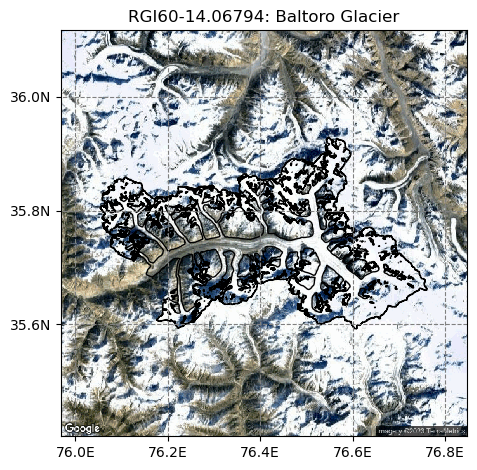

In [ ]:
graphics.plot_googlemap(baltoro.g)

In [ ]:
baltoro.outline.to_crs(baltoro.utm_crs).hvplot(color='None')*baltoro.centerline_gridded_data.itslive_v.hvplot(cmap='viridis')

:Overlay
   .Polygons.I :Polygons   [x,y]
   .Image.I    :Image   [x,y]   (itslive_v)

### Create object of `Point` class

In [ ]:
var_ls = ['v','vy','vx','v_error','mapping','satellite_img1','satellite_img2','acquisition_date_img1', 'acquisition_date_img2']

In [ ]:
baltoro_mid_point = setup.Point('Baltoro','baltoro_mid_point', 'RGI60-14.06794', baltoro, coords_utm_ls, 'EPSG:32643', var_ls)

original xy [76.35837062261048, 35.734956980210335] 4326 maps to datacube (622838.7460722262, 3955402.486507112) EPSG:32643
original xy [76.35837062261048, 35.734956980210335] 4326 maps to datacube (622838.7460722262, 3955402.486507112) EPSG:32643
subset and load at  72.83 seconds


In [ ]:
baltoro_mid_point.

<itslivetools.setup.Point>

You can view the different data contained in the `glacier` and `point` objects. The `Point` object contained the raw ITS_LIVE image pair data as it is accessed from AWS object storage as well as processed data. The processed data is denoted with 'TRIM' in the attribute name. Observations are filtered by temporal baseline of the image pair, ground sampling distance of the sensor and the long term flow speed of the glacier (from ITS_LIVE mosaic data). Filtering occurs in `_subset_ds_by_sensor_baseline()`.

In [ ]:
baltoro_mid_point.padded_centerline_subcube.v.mean(dim='mid_date').hvplot()

:Image   [x,y]   (v)

In [ ]:
baltoro_mid_point.TRIM_padded_centerline_subcube.v.mean(dim='mid_date').hvplot()

:Image   [x,y]   (v)

In [ ]:
baltoro_mid_point.TRIM_padded_centerline_subcube

<xarray.Dataset>
Dimensions:                (mid_date: 2854, y: 13, x: 84)
Coordinates:
  * mid_date               (mid_date) datetime64[ns] 2017-01-10T17:36:40.6606...
  * x                      (x) float64 6.177e+05 6.178e+05 ... 6.277e+05
  * y                      (y) float64 3.957e+06 3.957e+06 ... 3.956e+06
    step_count             (mid_date) int64 16210 17550 15587 ... 35962 19653
    mapping                int64 0
Data variables:
    v                      (mid_date, y, x) float32 nan nan nan ... nan nan nan
    vy                     (mid_date, y, x) float32 nan nan nan ... nan nan nan
    vx                     (mid_date, y, x) float32 nan nan nan ... nan nan nan
    v_error                (mid_date, y, x) float32 nan nan nan ... nan nan nan
    satellite_img1         (mid_date) object '2A' '2B' '2B' ... '2B' '2B' '2A'
    satellite_img2         (mid_date) object '2B' '2A' '2B' ... '2B' '2A' '2A'
    acquisition_date_img1  (mid_date) datetime64[ns] 2016-06-27T05:36:42 ... ...
    acquisition_date_img2  (mid_date) datetime64[ns] 2017-07-27T05:36:39 ... ...
    img_separation         (mid_date) float64 395.0 346.0 350.0 ... 106.0 101.0
Attributes: (12/19)
    Conventions:                CF-1.8
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               25-Sep-2023 21:40:31
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v2/N30E070/ITS_L...
    skipped_granules:           s3://its-live-data/datacubes/v2/N30E070/ITS_L...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

In [ ]:
baltoro_mid_point.TRIM_padded_centerline_subcube.v.mean(dim='mid_date').hvplot()*baltoro_mid_point.cube_around_point.mean(dim='mid_date').v.hvplot(cmap='plasma')

:Overlay
   .Image.I  :Image   [x,y]   (v)
   .Image.II :Image   [x,y]   (v)

In [ ]:
baltoro_mid_point.TRIM_cube_around_point.v.to_dataframe().reset_index().dropna()

,mid_date,y,x,step_count,mapping,v
0,2013-05-18 05:30:10.536076032,3955867.5,624652.5,12218,0,189.0
1,2013-05-18 05:30:10.536076032,3955867.5,624772.5,12218,0,184.0
2,2013-05-18 05:30:10.536076032,3955867.5,624892.5,12218,0,177.0
3,2013-05-18 05:30:10.536076032,3955747.5,624652.5,12218,0,193.0
4,2013-05-18 05:30:10.536076032,3955747.5,624772.5,12218,0,190.0
...,...,...,...,...,...,...
25757,2022-02-16 05:49:03.035076096,3955627.5,624892.5,7285,0,105.0
25777,2022-02-18 17:49:03.535076096,3955867.5,624772.5,5090,0,68.0
25778,2022-02-18 17:49:03.535076096,3955867.5,624892.5,5090,0,69.0
25780,2022-02-18 17:49:03.535076096,3955747.5,624772.5,5090,0,72.0
